## Extract Data

In [1]:
# importing required modules
from zipfile import ZipFile

# ***** RUN THIS ONCE *****
# specifying the zip file name
# file_name = "spotify_million_playlist_dataset.zip"

# opening the zip file in READ mode
# with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    # zip.printdir()
#     i = 0
#     print('Extracting all the files now...')
#     for name in zip.namelist():
#         if i > 20:
#             break
        
        # get the first 20 data files
 #        if name.startswith("data/m"):
#             zip.extract(name)
#             print(name)
#             i += 1
       
#     print('Done!')
    # extracting all the files
    # print('Extracting all the files now...')
    # zip.extractall()
    # print('Done!')

In [7]:
import os
import json
def loop_slices(path, num_slices=20):
    cnt = 0
    mpd_playlists = []
    filenames = os.listdir(path)
    for fname in sorted(filenames):
        print(fname)
        if fname.startswith("mpd.slice.") and fname.endswith(".json"):
            cnt += 1
            fullpath = os.sep.join((path, fname))
            f = open(fullpath)
            js = f.read()
            f.close()
            current_slice = json.loads(js)
            # Create a list of all playlists
            for playlist in current_slice['playlists']:
                mpd_playlists.append(playlist)
            if cnt == num_slices:
                break
    return mpd_playlists
# Path where the json files are extracted
path = '../spotify_data/data/'
playlists = loop_slices(path, num_slices=3)

mpd.slice.0-999.json
mpd.slice.1000-1999.json
mpd.slice.10000-10999.json


## Get Spotify API Data

In [8]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
# from tqdm import tqdm
# Spotify credentials
os.environ["SPOTIPY_CLIENT_ID"] = "bdf64242b8364ab5b264d3c14e8e9af6"
os.environ["SPOTIPY_CLIENT_SECRET"] = "3ed931eb80d8412292a50a10ed96e611"
os.environ['SPOTIPY_REDIRECT_URI'] = "http://localhost:5001"
sp = spotipy.Spotify(client_credentials_manager =      
                     SpotifyClientCredentials())
cols_to_keep = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']
dfs = []
for playlist in playlists[0:5]:
    audio_feats = []
    for track in playlist['tracks']:
        track_uri = track['track_uri'].split(":")[2]
        feature = sp.audio_features(track_uri)
        if feature:
            audio_feats.append(feature[0])
    feats = pd.DataFrame(audio_feats)[cols_to_keep]
    feats['name'] = playlist['name']
    feats['pid'] = playlist['pid']
    # avg_feats = pd.DataFrame(audio_feats)[cols_to_keep].mean()
    # avg_feats['name'] = playlist['name']
    # avg_feats['pid'] = playlist['pid']
    dfs.append(feats.T)

In [9]:
cluster_df = pd.concat(dfs[0:2], axis = 1).T
cluster_df = cluster_df.iloc[:, 0:(len(cluster_df.columns)-1)]
X = cluster_df.drop(columns = ['name'])
y = cluster_df[['name']]
X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.904,0.813,4,-7.105,0,0.121,0.0311,0.00697,0.0471,0.81,125.461,226864,4
1,0.774,0.838,5,-3.914,0,0.114,0.0249,0.025,0.242,0.924,143.04,198800,4
2,0.664,0.758,2,-6.583,0,0.21,0.00238,0.0,0.0598,0.701,99.259,235933,4
3,0.892,0.714,4,-6.055,0,0.141,0.201,0.000234,0.0521,0.817,100.972,267267,4
4,0.853,0.606,0,-4.596,1,0.0713,0.0561,0.0,0.313,0.654,94.759,227600,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,0.51,0.919,7,-8.244,1,0.0593,0.00205,0.809,0.068,0.386,141.053,265840,4
35,0.581,0.854,1,-8.485,0,0.0428,0.00197,0.0013,0.111,0.788,131.18,259840,4
36,0.293,0.787,5,-8.841,1,0.0438,0.00774,0.496,0.392,0.139,165.307,658987,4
37,0.528,0.557,2,-10.342,0,0.0315,0.245,0.0156,0.0958,0.357,121.732,285533,4


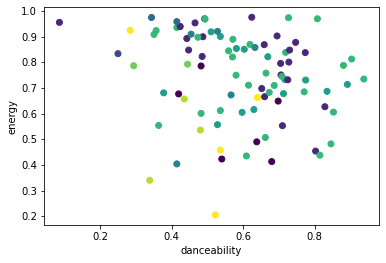

In [12]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X)
labels = kmeans.predict(X)
X['cluster'] = labels

plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels, cmap='viridis')
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])
plt.show()
